In [40]:
import pandas as pd
from typing import Literal
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy import stats

from utils.loader import MovieLensDataset
from arquitecture.Recommender import Recommender, Recommender_2
from arquitecture.components.PatterAnalyzer import PatternAnalyzer
import torch.optim as optim
import matplotlib.pyplot as plt
SEED = 55
BATCH = 2000
NUN_THREADS = 6
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCH = 150
LEARNING_RATE = 0.001


In [3]:
ml_path = "ml-100k"

train_dataset = MovieLensDataset(ml_path=ml_path, split="train", transpose_ratings=False, seed=SEED)
test_dataset = MovieLensDataset(ml_path=ml_path, split="test", transpose_ratings=False, seed=SEED)
val_dataset = MovieLensDataset(ml_path=ml_path, split="val", transpose_ratings=False, seed=SEED)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=NUN_THREADS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=True, num_workers=NUN_THREADS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH, shuffle=True, num_workers=NUN_THREADS)

In [5]:
user_data_tensor, rating_train_tensor, rating_test_tensor, _ = val_dataset.__getitem__(1)

print("User Data Tensor Size:", user_data_tensor.size())
print("Rating Train Tensor Size:", rating_train_tensor.size())
print("Rating Test Tensor Size:", rating_test_tensor.size())

User Data Tensor Size: torch.Size([23])
Rating Train Tensor Size: torch.Size([19, 22])
Rating Test Tensor Size: torch.Size([19])


In [7]:
height=19
width=22
user_input_size = 23
    # Crear instancia del modelo
pattern_analyzer = PatternAnalyzer(conv_structure=[1,8,8,16,16,32,32],
                            input_size=torch.Size((height, width)),
                            pool_depth=3,
                            expert_hidden_size=12,
                            expert_output_len=8,
                            final_mlp_factor=2,
                            final_mlp_output_len=12,
                            ).to(DEVICE)
    
model = Recommender(
        user_data_input_size=user_input_size,
        user_data_analizer_factor = 1,
        user_data_analizer_output_size = 10,
        pattern_analyzer=pattern_analyzer,
        final_regressor_factor=1,
        final_regressor_output_len=19
    ).to(DEVICE)

if os.path.exists("recommender_1.pth"):
    print("MODELO CARGADO UWU")
    model.load_state_dict(torch.load("recommender_1.pth", weights_only=True))

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

MODELO CARGADO UWU
Model parameters: 513534


In [5]:
# Crear el optimizador, por ejemplo, usando Adam con una tasa de aprendizaje de 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Crear la función de pérdida para regresión (Mean Squared Error Loss)
criterion = nn.MSELoss(reduction="sum")

In [ ]:
train_loss_record = []
valid_loss_record = []
for epoch in range(NUM_EPOCH):
    # --- Training Phase ---
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    
    for user_data_tensor, rating_train_tensor, rating_test_tensor, _ in train_dataloader:
        optimizer.zero_grad()

        outputs = model(user_data_tensor.float().to(DEVICE), rating_train_tensor.float().to(DEVICE)).to(DEVICE)        
        loss = criterion(outputs.to(DEVICE), rating_test_tensor.float().to(DEVICE)) 
        
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update model parameters
        running_train_loss += loss.item() * rating_test_tensor.size()[1]
    
    epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
    train_loss_record.append(epoch_train_loss)
    # --- Validation Phase ---32
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for user_data_tensor, rating_train_tensor, rating_test_tensor, _ in val_dataloader:
            
            outputs = model(user_data_tensor.float().to(DEVICE), rating_train_tensor.float().to(DEVICE))        
            loss = criterion(outputs, rating_test_tensor.float().to(DEVICE)) 
            
            running_val_loss += loss.item() * rating_test_tensor.size()[1]
    
    epoch_val_loss = running_val_loss / len(val_dataloader.dataset)
    valid_loss_record.append(epoch_val_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCH}] - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

Epoch [1/150] - Train Loss: 38.6441, Val Loss: 39.0035
Epoch [2/150] - Train Loss: 38.2989, Val Loss: 38.6461
Epoch [3/150] - Train Loss: 37.9568, Val Loss: 38.2878
Epoch [4/150] - Train Loss: 37.6146, Val Loss: 37.9296
Epoch [5/150] - Train Loss: 37.2733, Val Loss: 37.5655
Epoch [6/150] - Train Loss: 36.9266, Val Loss: 37.1973
Epoch [7/150] - Train Loss: 36.5758, Val Loss: 36.8111
Epoch [8/150] - Train Loss: 36.2084, Val Loss: 36.3941
Epoch [9/150] - Train Loss: 35.8118, Val Loss: 35.9656
Epoch [10/150] - Train Loss: 35.4019, Val Loss: 35.4746
Epoch [11/150] - Train Loss: 34.9332, Val Loss: 34.9594
Epoch [12/150] - Train Loss: 34.4388, Val Loss: 34.2637
Epoch [13/150] - Train Loss: 33.7696, Val Loss: 33.3340
Epoch [14/150] - Train Loss: 32.8847, Val Loss: 32.0264
Epoch [15/150] - Train Loss: 31.6464, Val Loss: 30.5996
Epoch [16/150] - Train Loss: 30.3761, Val Loss: 31.2726
Epoch [17/150] - Train Loss: 31.2188, Val Loss: 30.2988
Epoch [18/150] - Train Loss: 30.2997, Val Loss: 29.4139
E

In [ ]:
#torch.save(model.state_dict(), "recommender_1.pth")

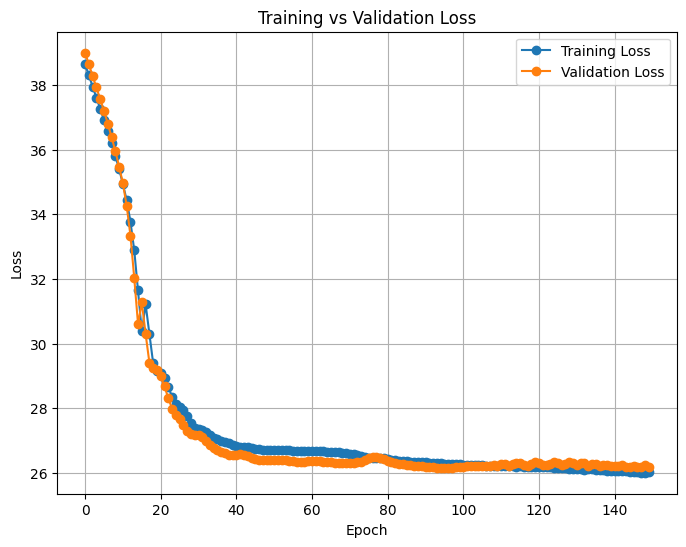

In [ ]:
# Create a plot with specified figure size
plt.figure(figsize=(8, 6))

# Plot training and validation loss records
plt.plot(train_loss_record, label="Training Loss", marker='o')
plt.plot(valid_loss_record, label="Validation Loss", marker='o')

# Adding labels and title for clarity
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

# Add a legend to differentiate the plots
plt.legend()

# Optionally add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()

In [66]:
genre = pd.read_csv(os.path.join(ml_path,"u.genre"),
                 sep='|',    
                 header=None,  
                 names=['genre_name', 'genre_id'])
        
columns = [
            'movie_id',
            'movie_title',
            'release_date',
            'video_release_date',
            'IMDb_URL'
        ] + genre["genre_name"].tolist()

movie = pd.read_csv(
            os.path.join(ml_path,"u.item"),
            sep='|',
            header=None,        
            names=columns,     
            encoding='latin-1'  
        ).drop(columns=['video_release_date', 'IMDb_URL'])
        
movie["release_date"] = pd.to_datetime(movie["release_date"], errors='coerce') - pd.Timestamp("1970-01-01")
movie['years_1970'] = movie['release_date'].dt.days / 365
movie = movie.drop(columns=['release_date', "movie_title", "movie_id", "years_1970"])[['Action', 'Adventure',
       'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western','unknown']]
movie

data = pd.read_csv(os.path.join(ml_path,"u.data"),
                 sep='\t',    
                 header=None,  
                 names=['user_id', 'item_id', 'rating', 'timestamp'])

data['timestamp'] = (data['timestamp'] - pd.Timestamp("1970-01-01").second )/(3600*24*365)
        
data

,user_id,item_id,rating,timestamp
0,196,242,3,27.944284
1,186,302,3,28.276184
2,22,377,1,27.869328
3,244,51,2,27.923862
4,166,346,1,28.107483
...,...,...,...,...
99995,880,476,3,27.910180
99996,716,204,5,27.898134
99997,276,1090,1,27.739593
99998,13,225,2,27.980694


In [67]:
def hit_rate(category_vector: list, threshold: int , user_id : int):
    
    recommended_movies = (movie * category_vector).sum(axis=1).nlargest(threshold).index
    
    reviewed_movies = data[data["user_id"] == int(user_id.detach().int())]
    mean = data[data["user_id"] == int(user_id.detach().int())]["rating"].mean()

    unseed_reviewed_movies = reviewed_movies[19:len(reviewed_movies)]
    liked_unseed_reviewed_movies = unseed_reviewed_movies[unseed_reviewed_movies["rating"] >= mean]["item_id"]
    
    return len(set(recommended_movies).intersection(set(liked_unseed_reviewed_movies)))

result = {}

model.eval()  # Set model to evaluation mode
running_val_loss = 0.0

with torch.no_grad():
    for user_data_tensor, rating_train_tensor, rating_test_tensor, user_id in test_dataloader: 
        
        outputs = model(user_data_tensor.float().to(DEVICE), rating_train_tensor.float().to(DEVICE)) 
        error = rating_test_tensor.to(DEVICE) - outputs
        
        MAPE = torch.abs(error * 100).mean(dim=0).detach().tolist()
        MAE = torch.abs(error).mean(dim=0).detach().tolist()
        MSE = torch.abs(error ** 2).mean(dim=0).detach().tolist()
        RMSE = torch.sqrt(torch.mean(error ** 2, dim=0)).detach().tolist()
        
        result['MAPE'] = MAPE
        result['MAE'] = MAE
        result['MSE'] = MSE
        result['RMSE'] = RMSE
        
        hit_rate_record = []
        
        for i in range(outputs.size()[0]):
            hit_rate_record.append(
                hit_rate(outputs[i].detach().tolist(), 100, user_id[i])
                )
        break

result["Genre"] = ['Action', 'Adventure',
       'Animation', 'Children_s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western','unknown']

pd.DataFrame(result).to_latex("Recommender_1_result.tex")
hit_rate_record

[2,
 6,
 0,
 17,
 1,
 21,
 9,
 0,
 5,
 3,
 5,
 12,
 1,
 0,
 3,
 6,
 6,
 4,
 0,
 2,
 9,
 12,
 6,
 1,
 9,
 0,
 0,
 8,
 9,
 1,
 6,
 8,
 1,
 15,
 5,
 7,
 1,
 3,
 5,
 7,
 10,
 4,
 1,
 0,
 12,
 3,
 5,
 7,
 13,
 1,
 2,
 0,
 0,
 3,
 7,
 1,
 7,
 2,
 2,
 5,
 0,
 3,
 16,
 2,
 1,
 5,
 4,
 0,
 0,
 2,
 0,
 9,
 1,
 0,
 0,
 6,
 0,
 0,
 3,
 2,
 5,
 1,
 5,
 0,
 7,
 0,
 6,
 5,
 20,
 5,
 6,
 4,
 7,
 1,
 10,
 0,
 2,
 7,
 10,
 0,
 0,
 9,
 2,
 0,
 0,
 10,
 3,
 0,
 0,
 7,
 8,
 7,
 5,
 1,
 0,
 1,
 1,
 1,
 0,
 9,
 12,
 0,
 1,
 1,
 0,
 0,
 0,
 7,
 1,
 21,
 0,
 37,
 2,
 0,
 0,
 9,
 12,
 7,
 4,
 4,
 3,
 1,
 21,
 1,
 0,
 0,
 0,
 0,
 8,
 20,
 0,
 0,
 2,
 6,
 6,
 4,
 0,
 2,
 9,
 1,
 0,
 2,
 0,
 13,
 2,
 0,
 6,
 6,
 2,
 0,
 6,
 9,
 0,
 24,
 5,
 0,
 5,
 3,
 2,
 0,
 2,
 12,
 0,
 1,
 4,
 3,
 0,
 4,
 7]

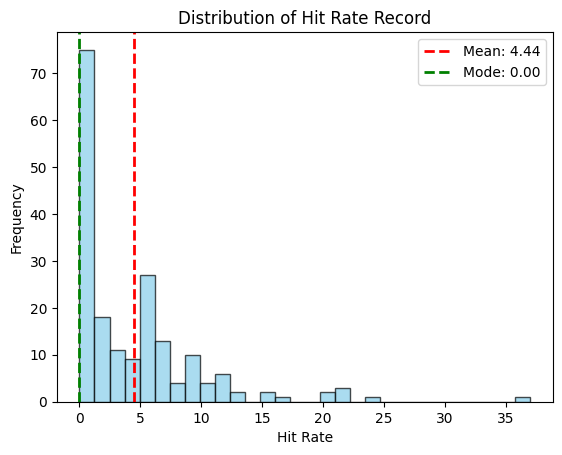

In [68]:
data = np.array(hit_rate_record)

# Calculate the mean.
mean_value = np.mean(data)

# Calculate the mode.
# Note: For continuous data, the mode might not be well-defined.
mode_result = stats.mode(data)
mode_value = mode_result.mode

# Plot the distribution.
plt.hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel("Hit Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Hit Rate Record")

# Plot vertical lines for mean and mode.
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, 
            label=f"Mean: {mean_value:.2f}")
plt.axvline(mode_value, color='green', linestyle='dashed', linewidth=2, 
            label=f"Mode: {mode_value:.2f}")

plt.legend()
plt.show()


In [ ]:
genre = pd.read_csv(os.path.join(ml_path,"u.genre"),
                 sep='|',    
                 header=None,  
                 names=['genre_name', 'genre_id'])
        
columns = [
            'movie_id',
            'movie_title',
            'release_date',
            'video_release_date',
            'IMDb_URL'
        ] + genre["genre_name"].tolist()

movie = pd.read_csv(
            os.path.join(ml_path,"u.item"),
            sep='|',
            header=None,        
            names=columns,     
            encoding='latin-1'  
        ).drop(columns=['video_release_date', 'IMDb_URL'])
        
movie["release_date"] = pd.to_datetime(movie["release_date"], errors='coerce') - pd.Timestamp("1970-01-01")
movie['years_1970'] = movie['release_date'].dt.days / 365
movie = movie.drop(columns=['release_date', "movie_title", "movie_id", "years_1970"])[['Action', 'Adventure',
       'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western','unknown']]
movie

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1678,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1679,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1680,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
